<a href="https://colab.research.google.com/github/levizwannah/drunk-detection-QCNN/blob/main/Sober_Drunk_Q_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data preprocessing
# first extract the frames from the tif files and save them individually.
# convert each frame to jpg

In [30]:
dsName = 'finalDataset'

In [31]:
from zmq.constants import Errno
import os
from PIL import Image

basePath = "/content/drive/MyDrive/isp2Data"
path = f"{basePath}/combined"
newDir = f"{basePath}/{dsName}"
drunkPath = f"{newDir}/drunk"
soberPath= f"{newDir}/sober"

if not os.path.isdir(newDir):
  os.mkdir(newDir)

if not os.path.isdir(drunkPath):
  os.mkdir(drunkPath)

if not os.path.isdir(soberPath):
  os.mkdir(soberPath)

lsdir = os.listdir(path)

for f in lsdir:  
    file, ext = os.path.splitext(f)
    labelInfo = file.split('_')

    # only allow eye and face in the dataset
    if(labelInfo[3] == 'r' or labelInfo[3] == 'h'):
      continue

    labelFolder = soberPath if(labelInfo[2] == '1') else drunkPath
    label = 'sober' if (labelFolder == soberPath) else 'drunk'

    bn = os.path.join(labelFolder, file)
    
    imgpath = os.path.join(path, f)
    try: 
      img = Image.open(imgpath)
      for i in range(50):
          try:
              img.seek(i)
              out = img.convert("RGB")
              out.save(f'{bn}_frame_{i}_{label}.jpeg', "JPEG", quality=100)

              # img.save(f'{bn}_frame_{i}_{label}.tif')
          except EOFError:
              break
    except Exception:
      continue

**Loading and Preprocessing the data**

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [32]:
import glob
dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"
allImages = glob.glob(f"{dataDir}/*/*.jpeg")
print("There are " + str(len(allImages)) + " JPEG Images in the main dataset")

There are 16250 JPEG Images in the main dataset


In [33]:
def plotImageFromDs(subDir, label, count):

  dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"
  i = 0
  counter = 1;
  plt.figure(figsize=(10, 10))
  for filename in os.listdir(f"{dataDir}/{subDir}"):
    i += 1

    if(i % 50 != 0):
      continue

    img = PIL.Image.open(dataDir + f"/{subDir}/" + filename)
    ax = plt.subplot(3, 3, counter)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

    if(counter == count): break

    counter += 1

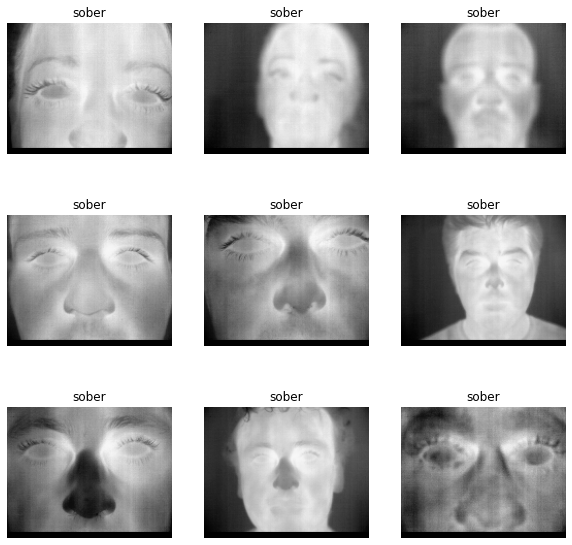

In [34]:
# sober Images
plotImageFromDs("sober", "sober", 9)

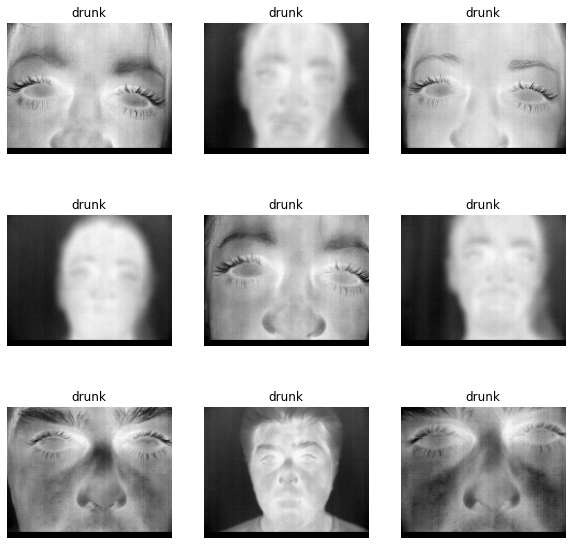

In [35]:
# drunk images
plotImageFromDs("drunk", "drunk", 9)

**Configuring the dataset for usage**

In [ ]:
# convert all image to jpeg


In [36]:
batchSize = 32
imgHeight = 128
imgWidth = 160
dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"

In [38]:
# training dataset  
trainDs = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split = 0.15,
    subset = "training",
    seed = 123,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

Found 16250 files belonging to 2 classes.
Using 13813 files for training.


In [39]:
# validation dataset
valDs = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split = 0.15,
    subset = "validation",
    seed = 123,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

Found 16250 files belonging to 2 classes.
Using 2437 files for validation.


In [42]:
# classes
classNames = trainDs.class_names
print(classNames)

['drunk', 'sober']


In [43]:
for imageBatch, labelsBatch in trainDs:
  print(imageBatch.shape)
  print(labelsBatch.shape)
  break

(32, 128, 160, 3)
(32,)


**Configuring dataset for performance**

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
trainDs = trainDs.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
valDs = trainDs.cache().prefetch(buffer_size = AUTOTUNE)

In [51]:
class QCNNModel:
  def __init__(self, numOfClasses, imageShape):
    self.model = Sequential(
        [
            layers.Rescaling(1./255, input_shape=imageShape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(numOfClasses)
        ]
    )

    self.epochs = 5
  
  def compile(self):
    self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
  def summary(self):
    self.model.summary()

  def train(self, trainDs, valDs, numOfEpochs):
    self.epochs = numOfEpochs
    self.history = self.model.fit(
        trainDs,
        validation_data = valDs,
        epochs = numOfEpochs
    )

  def inspect(self):
    history = self.history
    acc = history.history['accuracy']
    valAcc = history.history['val_accuracy']

    loss = history.history['loss']
    valLoss = history.history['val_loss']

    epochsRange = range(self.epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochsRange, acc, label='Training Accuracy')
    plt.plot(epochsRange, valAcc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochsRange, loss, label='Training Loss')
    plt.plot(epochsRange, valLoss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [52]:
qCnn = QCNNModel(len(classNames), (imgHeight, imgWidth, 3))
qCnn.compile()
qCnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 40, 64)       

**Training the Model**

In [53]:
epochs = 5
qCnn.train(trainDs, valDs, epochs)

Epoch 1/5
432/432 [==============================] - 330s 763ms/step - loss: 0.2878 - accuracy: 0.8670 - val_loss: 0.0585 - val_accuracy: 0.9742
Epoch 2/5
432/432 [==============================] - 329s 761ms/step - loss: 0.0479 - accuracy: 0.9733 - val_loss: 0.0453 - val_accuracy: 0.9752
Epoch 3/5
432/432 [==============================] - 336s 779ms/step - loss: 0.0452 - accuracy: 0.9752 - val_loss: 0.0445 - val_accuracy: 0.9752
Epoch 4/5
432/432 [==============================] - 328s 759ms/step - loss: 0.0668 - accuracy: 0.9663 - val_loss: 0.0945 - val_accuracy: 0.9589
Epoch 5/5
432/432 [==============================] - 328s 761ms/step - loss: 0.0481 - accuracy: 0.9744 - val_loss: 0.0455 - val_accuracy: 0.9752


**Inspecting the model**

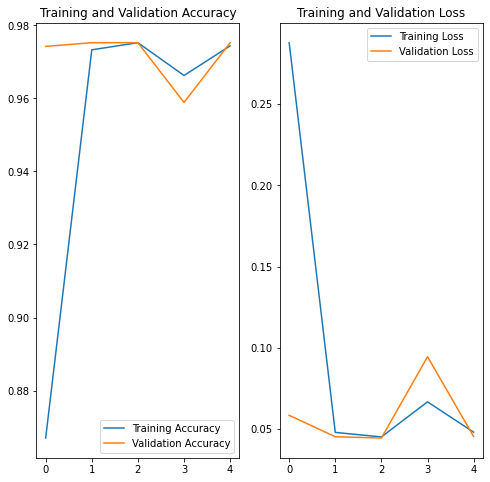

In [54]:
qCnn.inspect()

**Testing the model**

**Quantize the model**